In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import cm, colors
sns.set_theme()

import os 
os.chdir("..")
import init_simple_mdp as imdp


In [2]:
def color_map_color(value, cmap_name='Wistia', vmin=0, vmax=1):
    # norm = plt.Normalize(vmin, vmax)
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)  # PiYG
    rgb = cmap(norm(abs(value)))[:3]  # will return rgba, we take only first 3 so we get rgb
    color = colors.rgb2hex(rgb)
    return color

In [6]:
df = pd.read_csv('results/player10_noturn_results.csv')
df = df[['epsilon','tokens','score','optimal_value','optimal_policy']]

# Map to policy action names 
a_map = {i:imdp.a_list[i] for i in range(len(imdp.a_list))}
df['optimal_policy_name'] = df['optimal_policy'].map(a_map)

## 1.0 Calculate Spot Dart Handicaps

In [7]:
epsilon_list = list(df.epsilon.unique())
epsilon_list = list(range(1,10))
# epsilon_list = [1,2,4,8,16,32,64,128]
# epsilon_list = [1,2,4,6,8,10,12,14,16,18,20]

In [8]:
expected_throws_list = []
for epsilon in epsilon_list: 
    th = df.loc[(df.score==501) & (df.epsilon==epsilon) & (df.tokens==0)].optimal_value.values[0]
    expected_throws_list.append(th)

ppd_list = [501 / expected_throws_list[i] for i in range(len(expected_throws_list))]


In [9]:
ssl_list = []

for i in range(len(ppd_list)):

    for j in range(i,len(ppd_list)):

        hppd = ppd_list[i]
        lppd = ppd_list[j]

        ssl = round(501*(lppd/hppd))

        ssl_list.append([epsilon_list[i],epsilon_list[j],ssl])

#ssl_list

In [10]:
ssl_list_full = []

for ssl in ssl_list: 

    th1 = df.loc[(df.score==501) & (df.epsilon==ssl[0]) & (df.tokens==0)].optimal_value.values[0]
    th2 = df.loc[(df.score==ssl[2]) & (df.epsilon==ssl[1]) & (df.tokens==0)].optimal_value.values[0]

    ssl_list_full.append([ssl[0],ssl[1],ssl[2],th1,th2, th2-th1])

In [11]:
spot_point_df = pd.DataFrame(ssl_list_full,columns=['p1_epsilon','p2_epsilon','p2_starting_score','p1_expected_throws','p2_expected_throws','diff_expected_throws'])
spot_point_df.head()

,p1_epsilon,p2_epsilon,p2_starting_score,p1_expected_throws,p2_expected_throws,diff_expected_throws
0,1,1,501,15.854003,15.854003,0.000000
1,1,2,376,15.854003,16.606544,0.752541
2,1,3,311,15.854003,17.276087,1.422085
3,1,4,274,15.854003,18.018940,2.164937
4,1,5,248,15.854003,18.723984,2.869981


## 2. Relationship between PPD and Execution Error

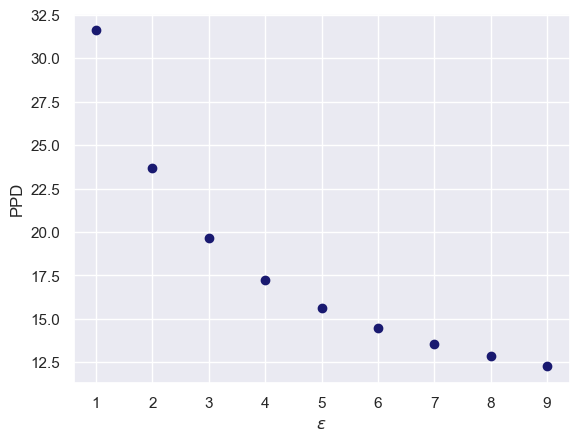

In [12]:
fig = plt.scatter(epsilon_list,ppd_list,color='midnightblue')
fig = plt.xlabel(r'$\epsilon$')
fig = plt.ylabel('PPD')
#fig = plt.title("Variation of PPD (for single game of 501) with Skill Level")


## 3. Equalization Error for Variance Differences in Skill Level 

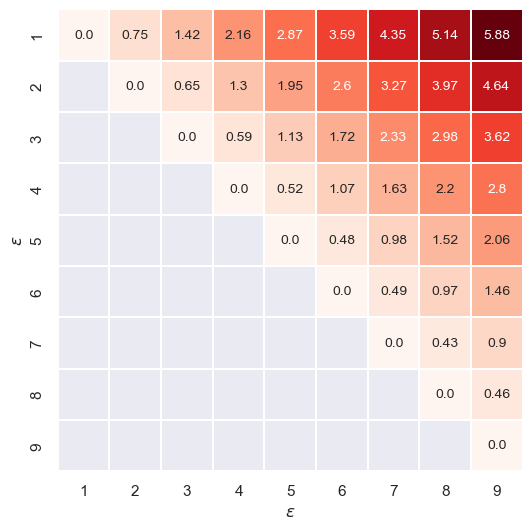

In [13]:
result = spot_point_df.pivot(index='p1_epsilon',columns='p2_epsilon',values='diff_expected_throws')
result = result.round(2)
#print(result)
#sns.heatmap(result,annot=labels,fmt="",cmap='RdYlGn',linewidths=0.30,ax=ax)
fig = sns.set(rc={'figure.figsize':(6,6)})
fig = sns.heatmap(result,annot=True,annot_kws={"size": 10},fmt="",cmap='Reds',linewidths=0.30,cbar=False)
#fig = plt.title("Difference in expected throws using spot point handicap system")
fig = plt.xlabel(r'$\epsilon$')
fig = plt.ylabel(r'$\epsilon$')

## 4. Change in PPD as the Game Progresses

In [14]:
df0 = df.loc[df.tokens==0].copy()
df0['ppd'] = df0.score / df0.optimal_value

# Create dataframes for values at 501 for each token value 
epsilon_dfs = []

for epsilon in range(1,11):
    
    temp = df0.loc[df0.epsilon==epsilon].set_index('score')['ppd'].copy()
    epsilon_dfs.append(temp)


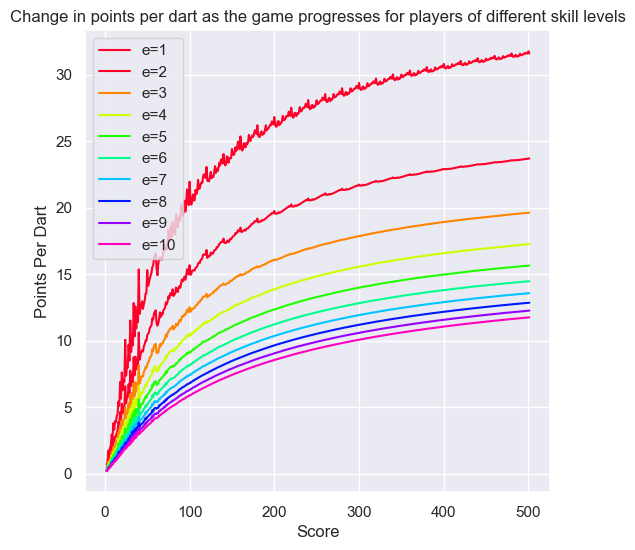

In [15]:
e_leg = []
vmax=max(epsilon_list)
vmin=min(epsilon_list)

# Plot each token line 
for epsilon in range(0,10):
    e_leg.append('e={}'.format(epsilon+1))
    color = color_map_color(epsilon, cmap_name='gist_rainbow', vmin=vmin, vmax=vmax)
    fig = plt.plot(epsilon_dfs[epsilon],color=color)

fig = plt.title('Change in points per dart as the game progresses for players of different skill levels')
fig = plt.xlabel('Score')
fig = plt.ylabel('Points Per Dart')
fig = plt.legend(e_leg)

## 5. Effectiveness of Spot Point Handicap at Creating Competitive Balance

In [16]:
df0 = df.loc[df.tokens==0].copy()
df0['ppd'] = df0.score / df0.optimal_value

# Create dataframes for values at 501 for each token value 
epsilon_dfs = []

for e in range(len(epsilon_list)):
    epsilon = epsilon_list[e]
    temp = df0.loc[df0.epsilon==epsilon].set_index('score')['optimal_value'].copy()
    epsilon_dfs.append(temp)


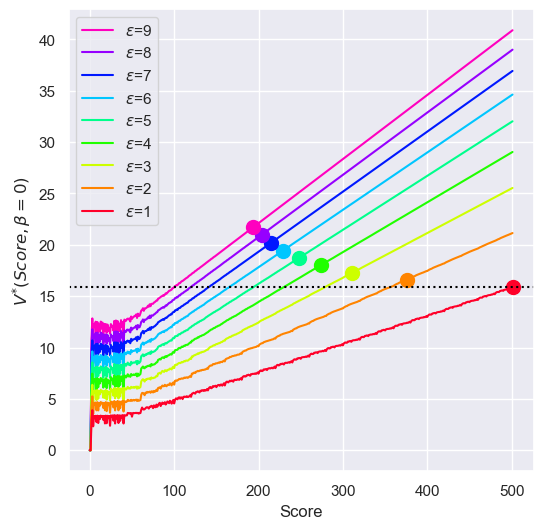

In [17]:
e_leg = []
vmax=max(epsilon_list)
vmin=min(epsilon_list)

# Plot each token line 
for e in reversed(range(len(epsilon_list))):
    epsilon = epsilon_list[e]
    e_leg.append(r'$\epsilon$={}'.format(epsilon))
    color = color_map_color(epsilon, cmap_name='gist_rainbow', vmin=vmin, vmax=vmax)
    fig = plt.plot(epsilon_dfs[e],color=color)

fig = plt.legend(e_leg) 

for e in range(len(epsilon_list)):
    epsilon = epsilon_list[e]
    color = color_map_color(epsilon, cmap_name='gist_rainbow', vmin=vmin, vmax=vmax)
    s = spot_point_df.loc[(spot_point_df.p1_epsilon==1) & (spot_point_df.p2_epsilon==epsilon)]['p2_starting_score'].values[0]
    fig = plt.plot(s, epsilon_dfs[e][s], marker="o", markersize=10, color=color)


#fig = plt.title('Change in expected remaining throws as the game progresses for players of different skill levels')
fig = plt.xlabel('Score')
fig = plt.axhline(epsilon_dfs[0][501],color='black',linestyle='dotted') 
fig = plt.ylabel(r'$V^{*}(Score,\beta=0)$')
fig = plt.legend(e_leg)

## 6. Our Handicap


### 6.1 Skill Estimation

In [18]:
import helpers as h
import function_board as fb
import init_simple_mdp as imdp

name_pa = 'player{}'.format(10)
data_parameter_dir = fb.data_parameter_dir

epsilon_list = list(range(1,10))

bullseye_probs = []
for epsilon in epsilon_list: 
    [aiming_grid, prob_grid_normalscore_nt, prob_grid_singlescore_nt, prob_grid_doublescore_nt, prob_grid_triplescore_nt, prob_grid_bullscore_nt] = h.load_aiming_grid(name_pa, epsilon=epsilon, data_parameter_dir=data_parameter_dir, grid_version='custom_no_tokens')
    bullseye_probs.append(prob_grid_bullscore_nt[728].copy())

load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_no_tokens/player10_e1_gaussin_prob_grid_custom_no_tokens.pkl
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_no_tokens/player10_e2_gaussin_prob_grid_custom_no_tokens.pkl
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_no_tokens/player10_e3_gaussin_prob_grid_custom_no_tokens.pkl
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_no_tokens/player10_e4_gaussin_prob_grid_custom_no_tokens.pkl
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_no_tokens/player10_e5_gaussin_prob_grid_custom_no_tokens.pkl
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_no_tokens/player10_e6_gaussin_prob_grid_custom_no_tokens.pkl
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_no_tokens/player10_e7_gaussin_prob_grid_custom_no_tokens.pkl
load_pickle from ./data_parameter/player_gaussin_fit/grid_custom_no_tokens/player10_e8_gaussin_prob_grid_custom_no_tok

In [19]:
prob_list = []

for i in range(len(epsilon_list)):
    db_prob = bullseye_probs[i][1]
    sb_prob = bullseye_probs[i][0]
    other = 1 - db_prob - sb_prob
    epsilon = epsilon_list[i]
    prob_list.append([epsilon,db_prob,sb_prob,other])


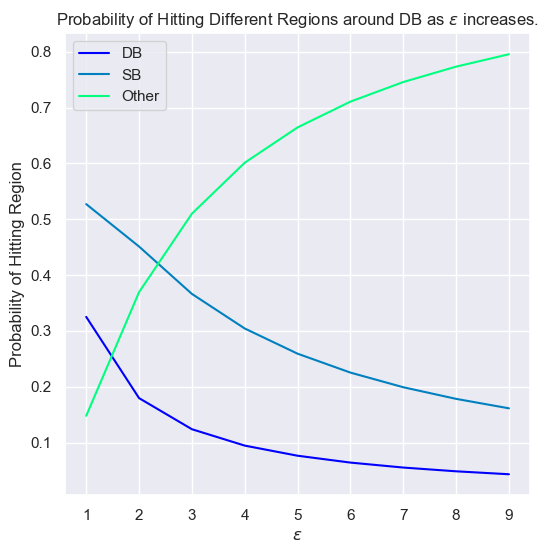

In [20]:
df_skill = pd.DataFrame(prob_list,columns= ['epsilon','DB','SB','Other'])
df_skill = df_skill.set_index('epsilon')
fig = df_skill.plot(colormap='winter')
fig = plt.xlabel('$\epsilon$')
fig = plt.ylabel('Probability of Hitting Region')
fig = plt.title('Probability of Hitting Different Regions around DB as $\epsilon$ increases.')

In [21]:
df_skill

,DB,SB,Other
epsilon,,,
1,0.325084,0.527009,0.147907
2,0.179611,0.451052,0.369336
3,0.123924,0.366238,0.509838
4,0.094572,0.304286,0.601142
5,0.076455,0.259175,0.664370
6,0.064161,0.225317,0.710522
7,0.055272,0.199109,0.745618
8,0.048546,0.178278,0.773176
9,0.043280,0.161346,0.795374


In [22]:
df_skill_n = df_skill * 30
df_skill_n_round = df_skill_n.round()

print(df_skill_n_round.sum(axis=1))
df_skill_n_round

epsilon
1    30.0
2    30.0
3    30.0
4    30.0
5    30.0
6    30.0
7    30.0
8    29.0
9    30.0
dtype: float64


,DB,SB,Other
epsilon,,,
1,10.0,16.0,4.0
2,5.0,14.0,11.0
3,4.0,11.0,15.0
4,3.0,9.0,18.0
5,2.0,8.0,20.0
6,2.0,7.0,21.0
7,2.0,6.0,22.0
8,1.0,5.0,23.0
9,1.0,5.0,24.0


In [23]:
df_skill_n.round(2)

,DB,SB,Other
epsilon,,,
1,9.75,15.81,4.44
2,5.39,13.53,11.08
3,3.72,10.99,15.30
4,2.84,9.13,18.03
5,2.29,7.78,19.93
6,1.92,6.76,21.32
7,1.66,5.97,22.37
8,1.46,5.35,23.20
9,1.30,4.84,23.86


In [25]:
df = pd.read_csv('results/player10_noturn_results.csv')
df = df[['epsilon','tokens','score','optimal_value','optimal_policy']]

# Map to policy action names 
a_map = {i:imdp.a_list[i] for i in range(len(imdp.a_list))}
df['optimal_policy_name'] = df['optimal_policy'].map(a_map)

epsilon_list = [1,2,3,4,5,6,7,8,9]

# Get dataframe only for score values at 501 
df_501 = df.loc[df.score==501]
#df_501 = df_501.loc[df_501.epsilon <= 10]

# Create dataframes for values at 501 for each token value 
epsilon_dfs = []

for e in range(len(epsilon_list)):
    epsilon = epsilon_list[e]
    temp = df_501.loc[df_501.epsilon==epsilon].set_index('tokens')['optimal_value'].copy()
    epsilon_dfs.append(temp)

In [26]:
def linear_interpolation(x1,x2,y1,y2,y):
    x = x1 - ((y1-y)/(y1-y2))*(x1-x2)
    return x 

In [27]:
handicap_vals = {}

for i in range(len(epsilon_list)):

    handicap_vals[epsilon_list[i]] = {}

for i in range(len(epsilon_list)):

    stronger_no_token = epsilon_dfs[i][0]

    for j in range(len(epsilon_list)):

        if epsilon_list[i] <= epsilon_list[j]: 

            df_j = epsilon_dfs[j]

            for b in range(1,len(df_j)):

                x1 = b-1
                x2 = b 
                y1 = df_j[b-1]
                y2 = df_j[b]

                if (stronger_no_token <= y1) & (stronger_no_token >= y2):

                    handicap = linear_interpolation(x1,x2,y1,y2,stronger_no_token)

                    handicap_vals[epsilon_list[i]][epsilon_list[j]] = handicap


In [28]:
handicap_list = []

for i in range(len(epsilon_list)):

    handicap_sub_list = []

    for j in range(len(epsilon_list)):

        try: 
            handicap = handicap_vals[epsilon_list[i]][epsilon_list[j]]
            handicap_sub_list.append(handicap)
        except: 
            handicap_sub_list.append(1000)
    
    handicap_list.append(handicap_sub_list)

In [29]:
df_handicap = pd.DataFrame(handicap_list)
df_handicap.index = epsilon_list
df_handicap.columns = epsilon_list
df_handicap = df_handicap.replace(1000,np.nan)
df_handicap = df_handicap.round(2)

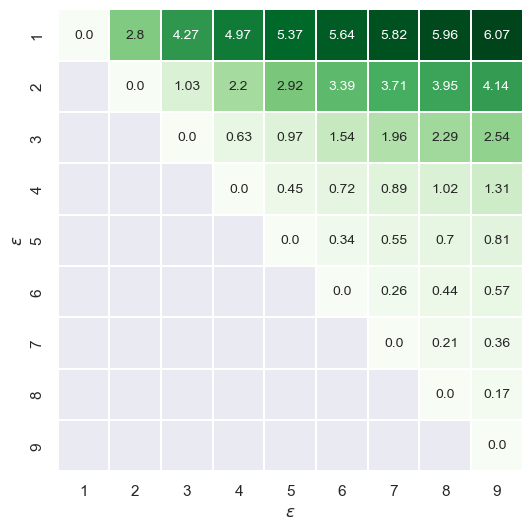

In [30]:
fig = sns.set(rc={'figure.figsize':(6,6)})
fig = sns.heatmap(df_handicap,annot=True,annot_kws={"size": 10},fmt="",cmap='Greens',linewidths=0.30,cbar=False)
#fig = plt.title("Difference in expected throws using spot point handicap system")
fig = plt.xlabel(r'$\epsilon$')
fig = plt.ylabel(r'$\epsilon$')

## Spot Point

In [31]:
df0 = df.loc[df.tokens==0].copy()

# Create dataframes for values at 501 for each token value 
epsilon_dfs = []

for e in range(len(epsilon_list)):
    epsilon = epsilon_list[e]
    temp = df0.loc[df0.epsilon==epsilon].set_index('score')['optimal_value'].copy()
    epsilon_dfs.append(temp)


In [32]:
handicap_vals = {}

for i in range(len(epsilon_list)):

    handicap_vals[epsilon_list[i]] = {}

for i in range(len(epsilon_list)):

    stronger_no_token = epsilon_dfs[i][501]

    for j in range(len(epsilon_list)):

        if epsilon_list[i] <= epsilon_list[j]: 

            df_j = epsilon_dfs[j]

            for s in range(1,len(df_j)):

                x1 = s-1
                x2 = s 
                y1 = df_j[s-1]
                y2 = df_j[s]

                # print(f"\t {i}-{j}-{s}")
                # print(stronger_no_token,y1,y2)

                if (stronger_no_token >= y1) & (stronger_no_token <= y2):

                    handicap = linear_interpolation(x1,x2,y1,y2,stronger_no_token)

                    handicap_vals[epsilon_list[i]][epsilon_list[j]] = handicap


In [33]:
handicap_list = []

for i in range(len(epsilon_list)):

    handicap_sub_list = []

    for j in range(len(epsilon_list)):

        try: 
            handicap = handicap_vals[epsilon_list[i]][epsilon_list[j]]
            handicap_sub_list.append(handicap)
        except: 
            handicap_sub_list.append(1000)
    
    handicap_list.append(handicap_sub_list)

In [34]:
df_handicap = pd.DataFrame(handicap_list)
df_handicap.index = epsilon_list
df_handicap.columns = epsilon_list
df_handicap = df_handicap.replace(1000,np.nan)
df_handicap = df_handicap.round(2)
df_handicap

,1,2,3,4,5,6,7,8,9
1,501.0,355.31,278.37,229.35,193.53,164.72,140.41,119.29,100.02
2,NaN,501.00,400.03,338.31,294.05,259.50,231.09,206.47,184.49
3,NaN,NaN,501.00,428.78,377.51,338.13,306.14,278.91,254.89
4,NaN,NaN,NaN,501.00,444.16,400.88,366.05,336.70,311.06
5,NaN,NaN,NaN,NaN,501.00,454.39,417.15,385.99,358.94
6,NaN,NaN,NaN,NaN,NaN,501.00,461.66,428.92,400.65
7,NaN,NaN,NaN,NaN,NaN,NaN,501.00,466.86,437.52
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,501.00,470.69
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,501.00


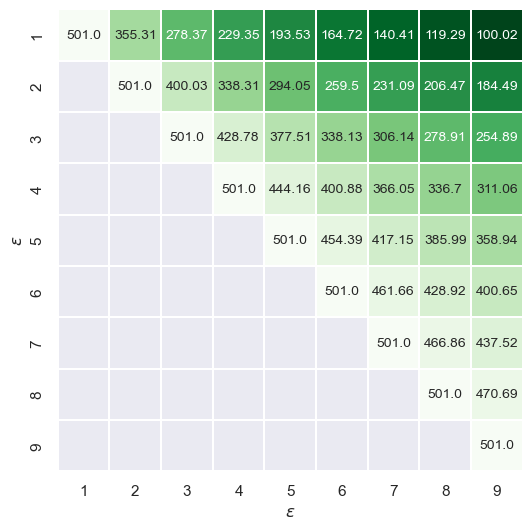

In [35]:
fig = sns.set(rc={'figure.figsize':(6,6)})
fig = sns.heatmap(df_handicap,annot=True,annot_kws={"size": 10},fmt="",cmap='Greens_r',linewidths=0.30,cbar=False)
#fig = plt.title("Difference in expected throws using spot point handicap system")
fig = plt.xlabel(r'$\epsilon$')
fig = plt.ylabel(r'$\epsilon$')

## Spot Dart

In [36]:
epsilon_list = [1,2,3,4,5,6,7,8,9,25,50,100]

df_501_b0 = df.loc[(df.score==501) & (df.tokens==0)]

In [37]:
handicap_list = []

for i in range(len(epsilon_list)):

    handicap_sub_list = []

    v501_i = df_501_b0[df_501_b0.epsilon==epsilon_list[i]].optimal_value.values[0]

    for j in range(len(epsilon_list)):

        v501_j = df_501_b0[df_501_b0.epsilon==epsilon_list[j]].optimal_value.values[0]

        handicap = v501_j - v501_i

        if handicap >= 0: 
            handicap_sub_list.append(handicap)
        else: 
            handicap_sub_list.append(1000)
    
    handicap_list.append(handicap_sub_list)

In [38]:
df_handicap = pd.DataFrame(handicap_list)
df_handicap.index = epsilon_list
df_handicap.columns = epsilon_list
df_handicap = df_handicap.replace(1000,np.nan)
df_handicap = df_handicap.round(2)
df_handicap

,1,2,3,4,5,6,7,8,9,25,50,100
1,0.0,5.29,9.68,13.18,16.17,18.77,21.07,23.14,25.03,46.93,75.41,129.50
2,NaN,0.00,4.39,7.89,10.88,13.48,15.78,17.85,19.74,41.64,70.12,124.21
3,NaN,NaN,0.00,3.50,6.49,9.09,11.39,13.46,15.35,37.25,65.73,119.83
4,NaN,NaN,NaN,0.00,2.99,5.59,7.89,9.96,11.85,33.75,62.23,116.32
5,NaN,NaN,NaN,NaN,0.00,2.60,4.90,6.97,8.86,30.76,59.24,113.33
6,NaN,NaN,NaN,NaN,NaN,0.00,2.30,4.37,6.26,28.16,56.64,110.73
7,NaN,NaN,NaN,NaN,NaN,NaN,0.00,2.07,3.96,25.86,54.34,108.43
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,1.89,23.79,52.27,106.36
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,21.90,50.38,104.47
25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,28.48,82.57


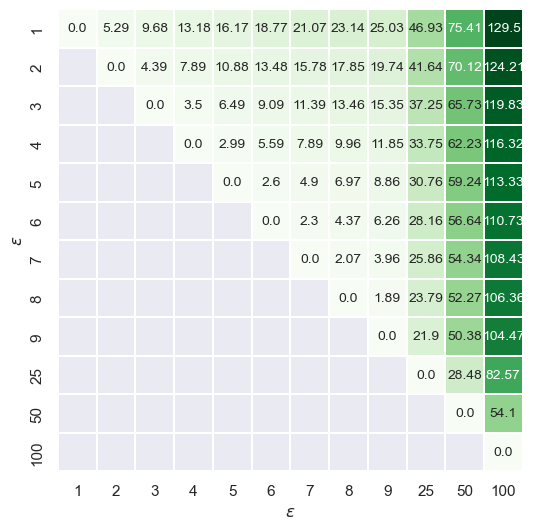

In [39]:
fig = sns.set(rc={'figure.figsize':(6,6)})
fig = sns.heatmap(df_handicap,annot=True,annot_kws={"size": 10},fmt="",cmap='Greens',linewidths=0.30,cbar=False)
#fig = plt.title("Difference in expected throws using spot point handicap system")
fig = plt.xlabel(r'$\epsilon$')
fig = plt.ylabel(r'$\epsilon$')

In [40]:
df.loc[(df.epsilon==9) & (df.tokens==8)][-50:-20]

,epsilon,tokens,score,optimal_value,optimal_policy,optimal_policy_name
44628,9,8,452,8.000000,771,T20
44629,9,8,453,8.000000,771,T20
44630,9,8,454,8.000000,750,DB
44631,9,8,455,8.000000,771,T20
44632,9,8,456,8.000000,771,T20
44633,9,8,457,8.000000,750,DB
44634,9,8,458,8.000000,771,T20
44635,9,8,459,9.000000,728,DB-c
44636,9,8,460,8.000000,750,DB
44637,9,8,461,8.000000,771,T20
